In [2]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
font = {'weight' : 'medium',
       'size'   : 13}
matplotlib.rc('font', **font)

#from csr2d.beam_conversion import particle_group_to_bmad, bmad_to_particle_group
#from pmd_beamphysics.plot import marginal_plot, density_plot
#from csr2d.simple_track import track_a_bend, track_a_drift, track_a_bend_parallel, track_a_drift_parallel

from csr2d.kick2 import csr2d_kick_calc, csr1d_steady_state_kick_calc

import time
import h5py

from pmd_beamphysics.interfaces.elegant import elegant_to_data
from pmd_beamphysics import ParticleGroup

import concurrent.futures as cf

import warnings
warnings.filterwarnings("ignore")

import scipy.constants
mec2 = scipy.constants.value('electron mass energy equivalent in MeV')*1e6
c_light = scipy.constants.c
e_charge = scipy.constants.e
r_e = scipy.constants.value('classical electron radius')

### Yunhai's beam for transient wakes

In [24]:
# Yunhai's beam for transient wakes

gamma = 5000
rho = 1.5 # Bend radius in m

rho = 1.5

# Total charge
Nb = 6.25e9
Q = e_charge * Nb

## Additional parameters
beta = (1-1/gamma**2)**(1/2)
mc2 = 510998.950
p0c = gamma * beta * mc2  # in eV

# fix random seed 
np.random.seed(0)

# Number of macro particles
Np = 1000000

# charge of one macro-particle
charges = np.ones(Np)*Q/Np  

# Beam emittance
norm_emit_x = 1e-6           # in m
emit_x = norm_emit_x / gamma # in m

sigma_x = 50e-6
sigma_xp = emit_x / sigma_x
sigma_y = 0
sigma_yp = 0
sigma_z  = 50e-6
sigma_delta = 0

beam = np.zeros((6, Np))
beam[0] = np.random.normal(0, sigma_x , size=(1, Np))
beam[1] = np.random.normal(0, sigma_xp , size=(1, Np))
beam[2] = np.random.normal(0, sigma_y , size=(1, Np))
beam[3] = np.random.normal(0, sigma_yp , size=(1, Np))
beam[4] = np.random.normal(0, sigma_z , size=(1, Np))
beam[5] = np.random.normal(0, sigma_delta , size=(1, Np))

# overtaking distance ( for Tao )
L0 = (24*sigma_z*rho**2)**(1/3)

# Characteristic wake in eV/m from Chris's paper
W0 = Nb* r_e * 510998.950 *(sigma_z/rho)**(2/3) / sigma_z**2

## code

In [4]:
# Copy of a section from kick2.py

from csr2d.convolution import fftconvolve2
from csr2d.kick2 import green_meshes
from scipy.signal import savgol_filter
from csr2d.central_difference import central_difference_z
from csr2d.deposit import split_particles, deposit_particles, histogram_cic_2d

def csr2d_kick_calc_case_B(
    z_b,x_b,weight,*,
    gamma=None,rho=None,nz=100,nx=100,xlim=None,zlim=None,
    map_f=map,
    species="electron",imethod='map_coordinates',debug=False):
    
    # Grid setup
    if zlim:
        zmin = zlim[0]
        zmax = zlim[1]
    else:
        zmin = z_b.min()
        zmax = z_b.max()

    if xlim:
        xmin = xlim[0]
        xmax = xlim[1]
    else:
        xmin = x_b.min()
        xmax = x_b.max()

    dz = (zmax - zmin) / (nz - 1)
    dx = (xmax - xmin) / (nx - 1)

    # Charge deposition
    t1 = time.time()
    charge_grid = histogram_cic_2d(z_b, x_b, weight, nz, zmin, zmax, nx, xmin, xmax)

    if debug:
        t2 = time.time()
        print("Depositing particles takes:", t2 - t1, "s")

    # Normalize the grid so its integral is unity
    norm = np.sum(charge_grid) * dz * dx
    lambda_grid = charge_grid / norm

    # Apply savgol filter
    lambda_grid_filtered = np.array([savgol_filter(lambda_grid[:, i], 13, 2) for i in np.arange(nx)]).T

    # Differentiation in z
    lambda_grid_filtered_prime = central_difference_z(lambda_grid_filtered, nz, nx, dz, order=1)

    # Grid axis vectors
    zvec = np.linspace(zmin, zmax, nz)
    xvec = np.linspace(xmin, xmax, nx)

    beta = np.sqrt(1 - 1 / gamma ** 2)

    t3 = time.time()

    # Creating the potential grids        
    psi_s_grid, psi_x_grid, zvec2, xvec2 = green_meshes(nz, nx, dz, dx, rho=rho, beta=beta)  
    
    if debug:
        t4 = time.time()
        print("Computing potential grids take:", t4 - t3, "s")

    # Compute the wake via 2d convolution
    conv_s, conv_x = fftconvolve2(lambda_grid_filtered_prime, psi_s_grid, psi_x_grid)
    
    if debug:
        t5 = time.time()
        print("Convolution takes:", t5 - t4, "s")

    Ws_grid = (beta ** 2 / abs(rho)) * (conv_s) * (dz * dx)
    Wx_grid = (beta ** 2 / abs(rho)) * (conv_x) * (dz * dx)
    
    return zvec,xvec,zvec2,xvec2, lambda_grid_filtered, lambda_grid_filtered_prime, psi_s_grid, psi_x_grid, Ws_grid, Wx_grid, dz, dx

In [43]:
zvec,xvec,zvec2,xvec2, lambda_grid_filtered, lambda_grid_filtered_prime, psi_s_grid, psi_x_grid, Ws_grid, Wx_grid, dz, dx = csr2d_kick_calc_case_B(beam[4,:], beam[0,:], 
                                           charges, gamma=gamma, rho=rho, 
                                           nz=300, nx=200,
                                           map_f = map, debug=True)

Depositing particles takes: 0.013727664947509766 s
Computing potential grids take: 0.015455245971679688 s
Convolution takes: 0.030328750610351562 s


Text(0.5, 0.92, '$\\psi_x$ benchmarking')

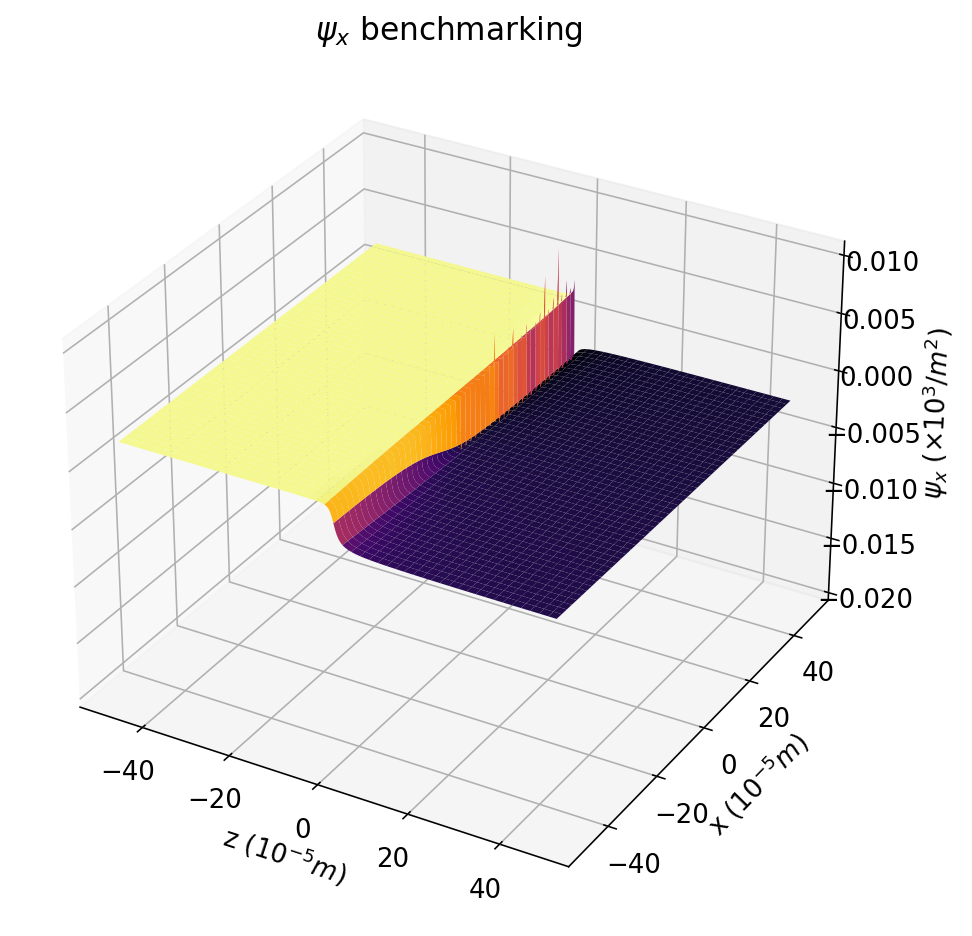

In [99]:
from mpl_toolkits import mplot3d
Z2, X2 = np.meshgrid(zvec2, xvec2, indexing='ij')

# plotting the surface from numerical computation
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(Z2*1e5, X2*1e5, psi_x_grid*1e-3 , cmap='inferno', zorder=1)


ax.set_xlabel(r'z $(10^{-5}m)$')
ax.set_ylabel(r'x $(10^{-5}m)$')
ax.set_zlabel(r'$\psi_x$ $(\times 10^3/m^2)$ ')
ax.zaxis.labelpad = 10
ax.set_title(r'$\psi_x$ benchmarking')

Text(0.5, 0.92, '$W_x$ benchmarking')

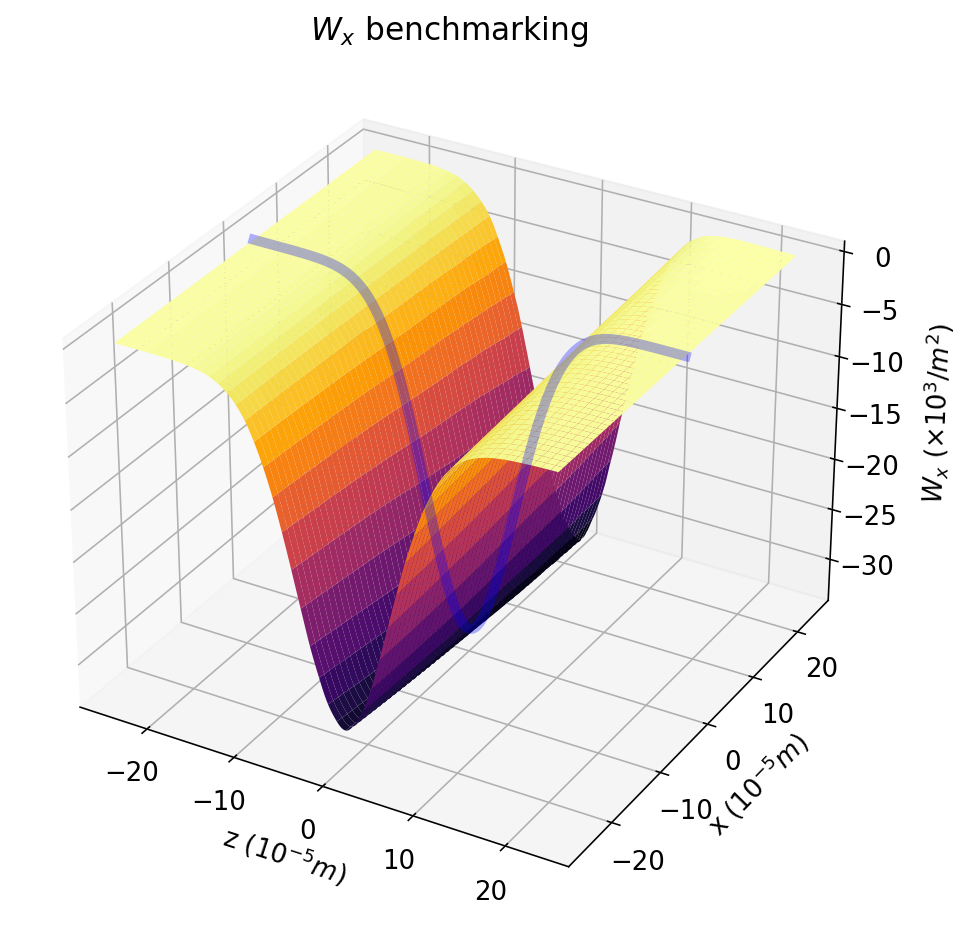

In [92]:
from mpl_toolkits import mplot3d
Z, X = np.meshgrid(zvec, xvec, indexing='ij')

# plotting the surface from numerical computation
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(Z*1e5, X*1e5, Wx_grid*1e-3 , cmap='inferno', zorder=1)

# plotting the theory curve
zline = np.linspace(min(zvec), max(zvec), 1000)
xline = np.zeros(len(zline))
fline = (-4.0/rho)*np.exp(-(zline/sigma_z)**2/2)/np.sqrt(2*np.pi)/sigma_z
ax.plot3D(zline*1e5, xline*1e5, fline*1e-3, 'blue', linewidth=5, zorder=3, alpha=0.3)


ax.set_xlabel(r'z $(10^{-5}m)$')
ax.set_ylabel(r'x $(10^{-5}m)$')
ax.set_zlabel(r'$W_x$ $(\times 10^3/m^2)$ ')
ax.zaxis.labelpad = 10
ax.set_title(r'$W_x$ benchmarking')

#ax.azim = 90

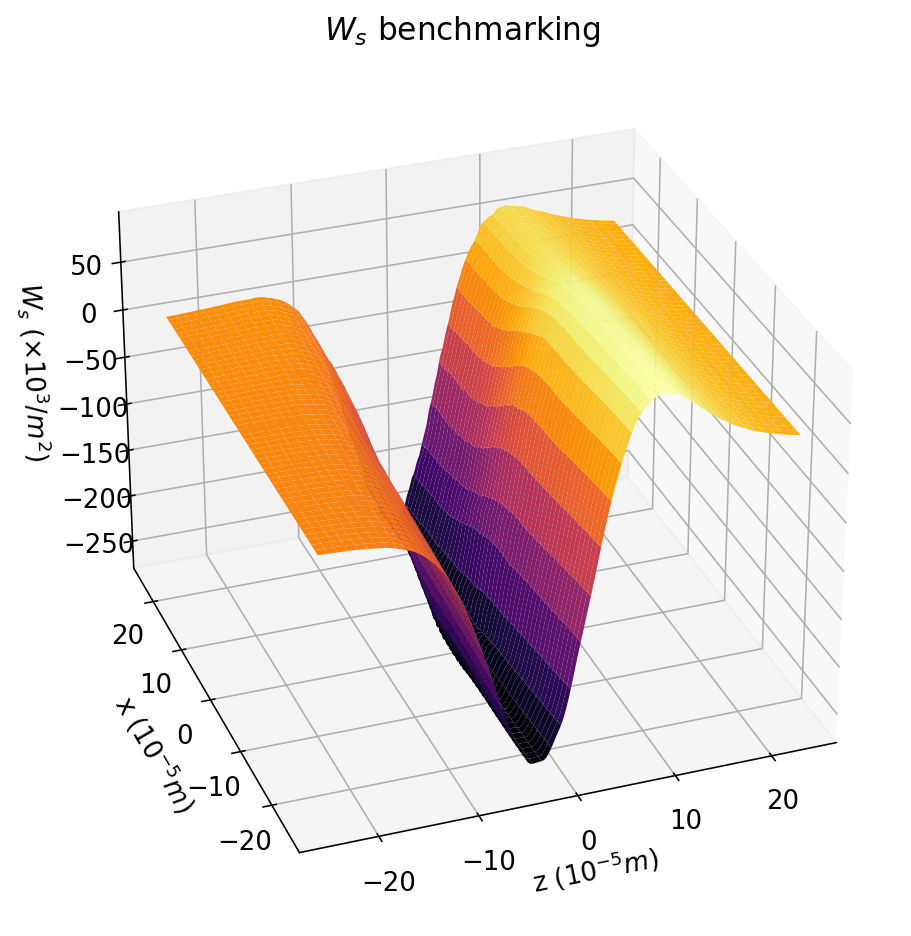

In [7]:
Z, X = np.meshgrid(zvec, xvec, indexing='ij')

# plotting the surface from numerical computation
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(Z*1e5, X*1e5, Ws_grid*1e-3 , cmap='inferno', zorder=1)

# plotting the theory curve
#zline = np.linspace(min(zvec), max(zvec), 1000)
#xline = np.zeros(len(zline))
#fline = (-4.0/rho)*np.exp(-(zline/sigma_z)**2/2)/np.sqrt(2*np.pi)/sigma_z
#ax.plot3D(zline*1e5, xline*1e5, fline*1e-3, 'blue', linewidth=5, zorder=3, alpha=0.3)


ax.set_xlabel(r'z $(10^{-5}m)$')
ax.set_ylabel(r'x $(10^{-5}m)$')
ax.set_zlabel(r'$W_s$ $(\times 10^3/m^2)$ ')
ax.zaxis.labelpad = 10
ax.set_title(r'$W_s$ benchmarking')

ax.azim = 250

#### psi_s(zi) depends on (x-x') only
#### Fix observation x to be x_o as before, then psi_s(zi) is psi_s_zi_vec(x')

In [36]:
# Bypassing the beam, use smooth Gaussian distribution

def lamb_2d(z,x):
    return 1/(2*np.pi*sigma_x*sigma_z)* np.exp(-z**2 / 2 / sigma_z**2 - x**2 / 2 / sigma_x**2)
def lamb_2d_prime(z,x):
    return 1/(2*np.pi*sigma_x*sigma_z)* np.exp(-z**2 / 2 / sigma_z**2 - x**2 / 2 / sigma_x**2) * (-z / sigma_z**2)

In [67]:
nz = 301
nx = 301

zvec = np.linspace(-5*sigma_z, 5*sigma_z, nz)
xvec = np.linspace(-5*sigma_x, 5*sigma_x, nx)
zm, xm = np.meshgrid(zvec, xvec, indexing='ij')

lambda_grid_filtered = lamb_2d(zm,xm)
lambda_grid_filtered_prime = lamb_2d_prime(zm,xm)

dz = (10*sigma_z) / (nz - 1)
dx = (10*sigma_x) / (nx - 1)

psi_s_grid, psi_x_grid, zvec2, xvec2 = green_meshes(nz, nx, dz, dx, rho=rho, beta=beta)  

In [68]:
# phi is the angle into the bend 
# x_observe should be a value in x_vec ( zero might not be one )..... TO BE FIXED

# The code here will replace the convolution section in the "csr2d_kick_calc_case_B" above

from csr2d.core2 import psi_s, psi_x0
from scipy.interpolate import RectBivariateSpline

def compute_transient_wake_case_B(phi, x_observe, zvec2, xvec2, dz, dx, lambda_grid_filtered_prime, psi_s_grid, psi_x_grid):

    # Boundary condition 
    temp = (x_observe - xvec2)/rho
    zi_vec = rho*( phi - beta*np.sqrt(temp**2 + 4*(1+temp)*np.sin(phi/2)**2))
    zo_vec = -beta*np.abs(x_observe - xvec2)

    ## condition_grid = np.array([(zvec2 < zi_vec[i]) for i in range(len(xvec2))])   
    # Computing the integral term of case B
    # Want "True" if (z > zi) OR (z < zo), where the potential values are set to ZERO
    condition_grid = np.array([(zvec2 > zi_vec[i]) | (zvec2 < zo_vec[i]) for i in range(len(xvec2))])
    psi_s_grid_bounded = np.where(condition_grid.T, 0, psi_s_grid)
    psi_x_grid_bounded = np.where(condition_grid.T, 0, psi_x_grid)
      
    
 #   plt.imshow(psi_x_grid.T, origin='lower')
 #   plt.imshow(psi_x_grid_bounded.T, origin='lower')
    
    # plotting the surface from numerical computation
 #   Z2, X2 = np.meshgrid(zvec2, xvec2, indexing='ij')
 #   fig, ax = plt.subplots(figsize=(8,8))
 #   ax = plt.axes(projection='3d')
 #   ax.plot_surface(Z2*1e5, X2*1e5, psi_x_grid_bounded *1e-3 , cmap='inferno', zorder=1)
    
    conv_s, conv_x = fftconvolve2(lambda_grid_filtered_prime, psi_s_grid_bounded, psi_x_grid_bounded)
    Ws_grid = (beta**2 / abs(rho)) * (conv_s) * (dz * dx)
    Wx_grid = (beta**2 / abs(rho)) * (conv_x) * (dz * dx)
    
    # Computing the two boundary terms of case B 
    # ==========================================
    lambda_interp = RectBivariateSpline(zvec, xvec, lambda_grid_filtered)  # lambda lives in the observation grid
    
    lambda_zi_vec = lambda z: lambda_interp.ev( z - zi_vec, xvec2 )
    
    psi_s_zi_vec = psi_s(zi_vec/2/rho, temp, beta)
    Ws_zi = lambda z: (beta**2 / rho) * np.dot(psi_s_zi_vec, lambda_zi_vec(z))*dx
    Ws_zi_vec = np.array(list(map(Ws_zi, zvec)))
    
    psi_x_zi_vec = psi_x0(zi_vec/2/rho, temp, beta, dx)
    Wx_zi = lambda z: (beta**2 / rho) * np.dot(psi_x_zi_vec, lambda_zi_vec(z))*dx
    Wx_zi_vec = np.array(list(map(Wx_zi, zvec)))
    
    
    lambda_zo_vec = lambda z: lambda_interp.ev( z - zo_vec, xvec2 )
    
    psi_s_zo_vec = psi_s(zo_vec/2/rho, temp, beta)
    Ws_zo = lambda z: (-1.0) * (beta**2 / rho) * np.dot(psi_s_zo_vec, lambda_zo_vec(z))*dx
    Ws_zo_vec = np.array(list(map(Ws_zo, zvec)))
    
    psi_x_zo_vec = psi_x0(zo_vec/2/rho, temp, beta, dx)
    Wx_zo = lambda z: (-1.0) * (beta**2 / rho) * np.dot(psi_x_zo_vec, lambda_zo_vec(z))*dx
    Wx_zo_vec = np.array(list(map(Wx_zo, zvec)))
    
    # ==========================================
    
    x_observe_index = np.argmin(np.abs(xvec - x_observe))
    print('x_observe_index :', x_observe_index )

    #return zi_vec, psi_s_zi_vec, W_zi_vec 
    return Ws_grid[:,x_observe_index], Ws_zi_vec, Ws_zo_vec, Wx_grid[:,x_observe_index], Wx_zi_vec, Wx_zo_vec

    #return psi_x_zo_vec
    #return zo_vec


In [ ]:
lambda_grid_filtered_prime

In [ ]:
lambda_grid_filtered_prime, psi_s_grid,

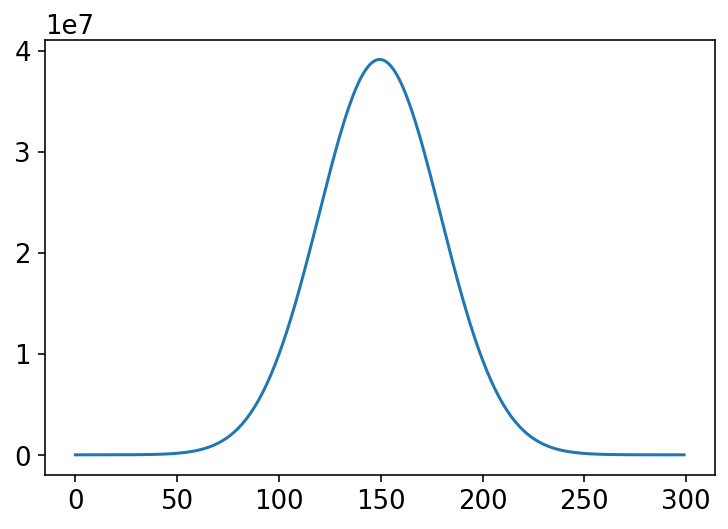

In [48]:
plt.plot(lambda_grid_filtered[:,120])

In [185]:
#@njit
# njit doesn't like the condition grid and interpolation....

def transient_calc_lambda(phi, z_observe, x_observe, zvec, xvec, dz, dx, lambda_grid_filtered_prime, psi_s_grid, psi_x_grid):

    x_observe_index = np.argmin(np.abs(xvec - x_observe))
    #print('x_observe_index :', x_observe_index )
    z_observe_index = np.argmin(np.abs(zvec - z_observe))
    #print('z_observe_index :', z_observe_index )

    # Boundary condition 
    temp = (x_observe - xvec)/rho
    zi_vec = rho*( phi - beta*np.sqrt(temp**2 + 4*(1 + temp)*np.sin(phi/2)**2))
    zo_vec = -beta*np.abs(x_observe - xvec)


    condition_grid = np.array([(zvec > z_observe - zo_vec[i]) | (zvec < z_observe - zi_vec[i]) for i in range(len(xvec))])

    lambda_grid_filtered_prime_bounded = np.where(condition_grid.T, 0, lambda_grid_filtered_prime)
    
    conv_s = my_2d_convolve2(lambda_grid_filtered_prime_bounded, psi_s_grid, z_observe_index, x_observe_index) 
    conv_x = my_2d_convolve2(lambda_grid_filtered_prime_bounded, psi_x_grid, z_observe_index, x_observe_index)  
    
    ##conv_s, conv_x = fftconvolve2(lambda_grid_filtered_prime_bounded, psi_s_grid, psi_x_grid)
    Ws_grid = (beta**2 / abs(rho)) * (conv_s) * (dz * dx)
    Wx_grid = (beta**2 / abs(rho)) * (conv_x) * (dz * dx)

    lambda_interp = RectBivariateSpline(zvec, xvec, lambda_grid_filtered)  # lambda lives in the observation grid
    lambda_zi_vec = lambda_interp.ev( z_observe - zi_vec, xvec )   
    psi_x_zi_vec = psi_x0(zi_vec/2/rho, temp, beta, dx)
    Wx_zi = (beta**2 / rho) * np.dot(psi_x_zi_vec, lambda_zi_vec)*dx

    lambda_zo_vec = lambda_interp.ev( z_observe - zo_vec, xvec )   
    psi_x_zo_vec = psi_x0(zi_vec/2/rho, temp, beta, dx)
    Wx_zo = (beta**2 / rho) * np.dot(psi_x_zo_vec, lambda_zo_vec)*dx
    
    #return Wx_grid[ z_observe_index ][ x_observe_index ], Wx_zi, Wx_zo
    return Wx_grid, Wx_zi, Wx_zo
    #return Wx_grid

In [ ]:
Z, X = np.meshgrid(zvec, xvec, indexing='ij')

In [193]:
def transient_calc_lambda_super(z_observe, x_observe):
    return transient_calc_lambda(phi, z_observe, x_observe, zvec, xvec, dz, dx,lambda_grid_filtered_prime, psi_s_grid, psi_x_grid)

In [212]:
def transient_calc_lambda_super(z_observe):
    return transient_calc_lambda(phi, z_observe, 2.5*sigma_x, zvec, xvec, dz, dx,lambda_grid_filtered_prime, psi_s_grid, psi_x_grid)

In [195]:
transient_calc_lambda_super(0,2.5*sigma_x)

(-9498.091821958586, -11011.78851049377, -1637.3574761133812)

In [ ]:
kaka.reshape(zm2.shape)

In [200]:
t1 = time.time()
with cf.ProcessPoolExecutor(max_workers=20) as executor:
    result = executor.map(transient_calc_lambda_super, Z.flatten(), X.flatten())
    gg = np.array(list(result))
    
t2 = time.time()
print('Mapping takes:', t2-t1, 'sec')

Mapping takes: 129.43536901474 sec


In [213]:
t1 = time.time()
with cf.ProcessPoolExecutor(max_workers=20) as executor:
    result = executor.map(transient_calc_lambda_super, zvec)
    g0 = np.array(list(result))
    
t2 = time.time()
print('Mapping takes:', t2-t1, 'sec')

Mapping takes: 0.952833890914917 sec


In [214]:
gaga1 = g0[:,0].reshape(Z.shape)
gaga2 = g0[:,1].reshape(Z.shape)
gaga3 = g0[:,2].reshape(Z.shape)

ValueError: cannot reshape array of size 301 into shape (301,301)

In [217]:
g0[:,0].shape

(301,)

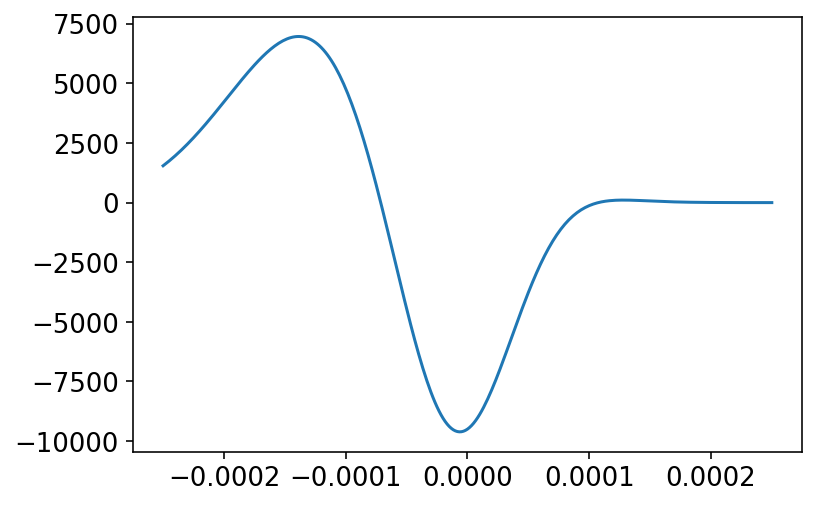

In [215]:
plt.plot(zvec,g0[:,0])

In [223]:
kaka = np.array(list(zip(zvec,g0[:,0])))

In [224]:
np.savetxt("Wx_int_x_2.5sig_new_absorb.txt",kaka)

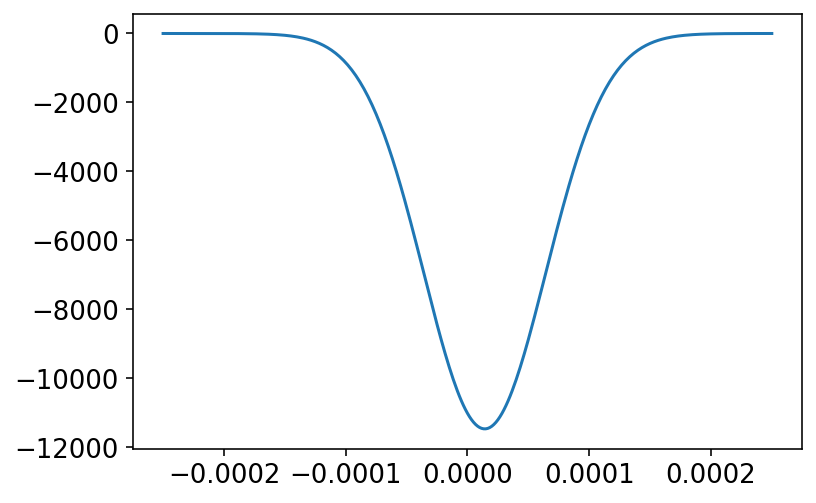

In [219]:
plt.plot(zvec,g0[:,1])

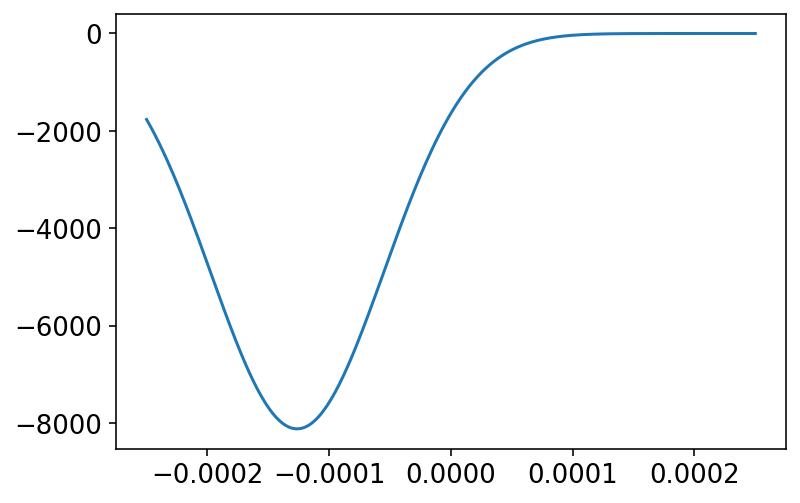

In [220]:
plt.plot(zvec,g0[:,2])

In [111]:
transient_calc_lambda_super(0)

-9498.091821958647

In [102]:
transient_calc_lambda(phi, 0, 2.5*sigma_x, zvec, xvec, dz, dx, lambda_grid_filtered_prime, psi_s_grid, psi_x_grid)

x_observe_index : 225
z_observe_index : 150


-9498.091821958647

In [99]:
Wx_grid[ z_observe_index ][x_observe_index]

-9498.091821958647

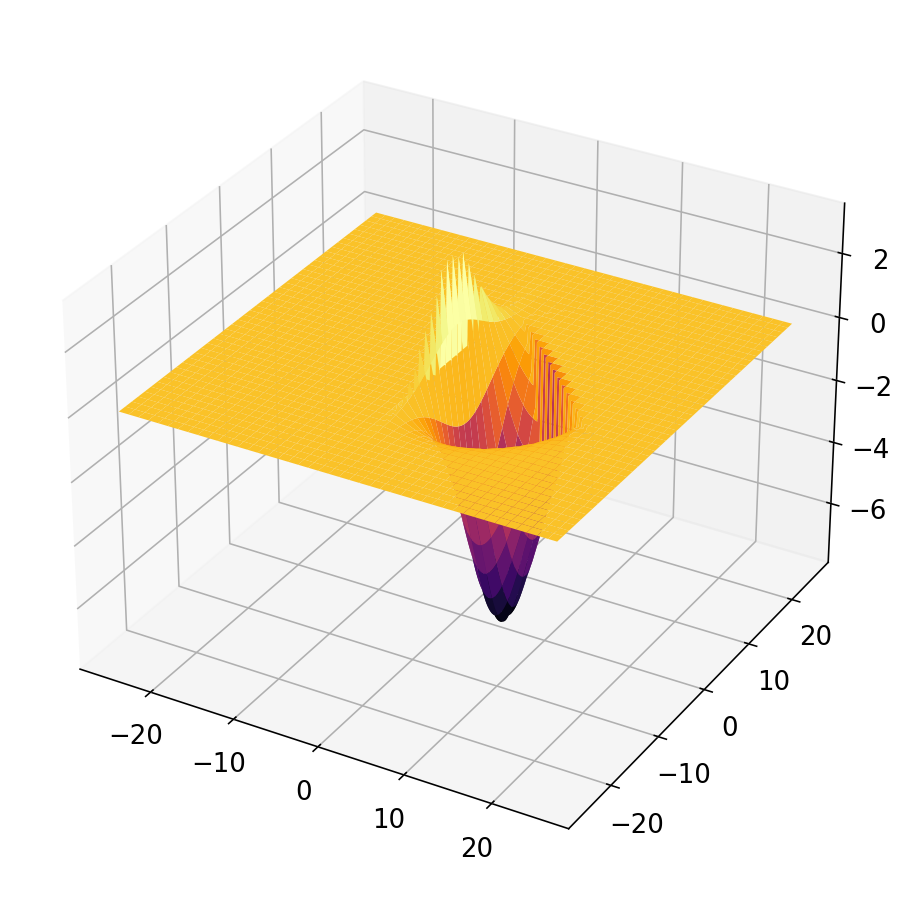

In [228]:
Z, X = np.meshgrid(zvec, xvec, indexing='ij')
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(Z*1e5, X*1e5, lambda_grid_filtered_prime_bounded  *1e-3 , cmap='inferno', zorder=1)

Text(0.5, 0.92, '$W_x$ zo boundary term')

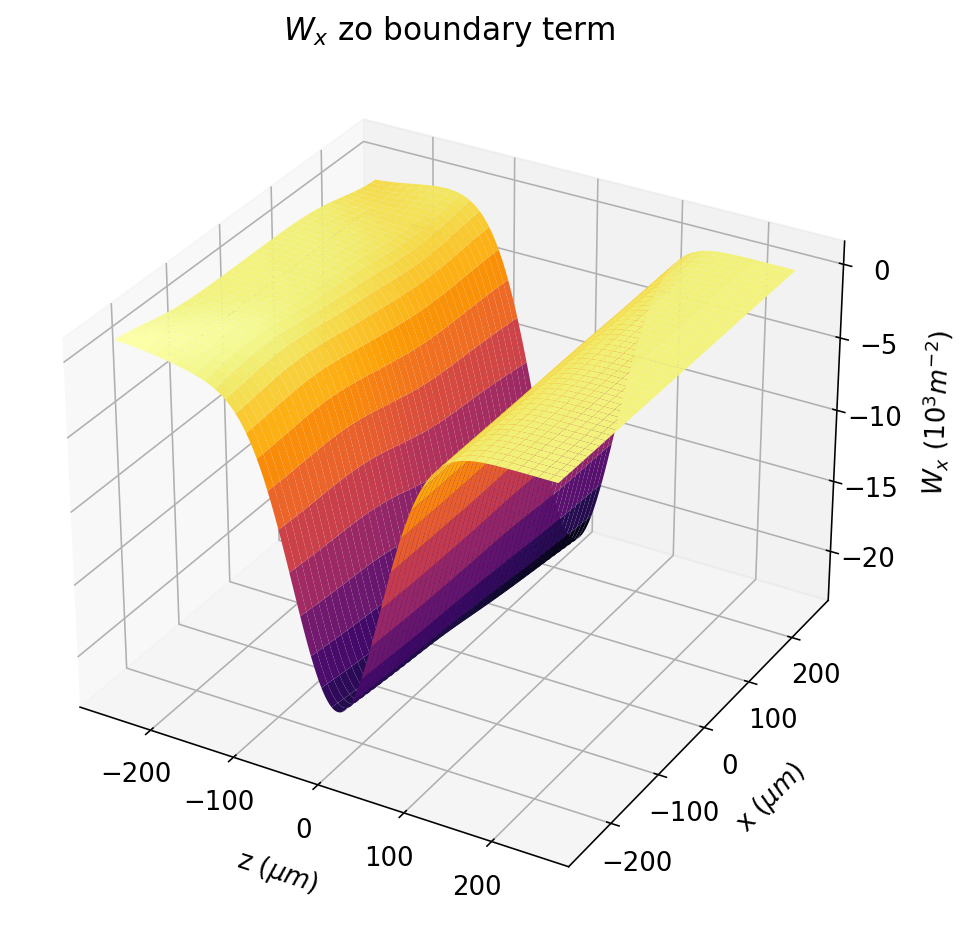

In [235]:
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(Z*1e6, X*1e6, (gaga1+gaga2+gaga3)*1e-3 , cmap='inferno', zorder=1)

ax.set_xlabel(r'z $(\mu m)$', labelpad = 10)
ax.set_ylabel(r'x $(\mu m)$', labelpad = 10)
ax.set_zlabel(r'$W_x$ $(10^3 m^{-2})$ ')
ax.zaxis.labelpad = 10
ax.set_title(r'$W_x$ zo boundary term')

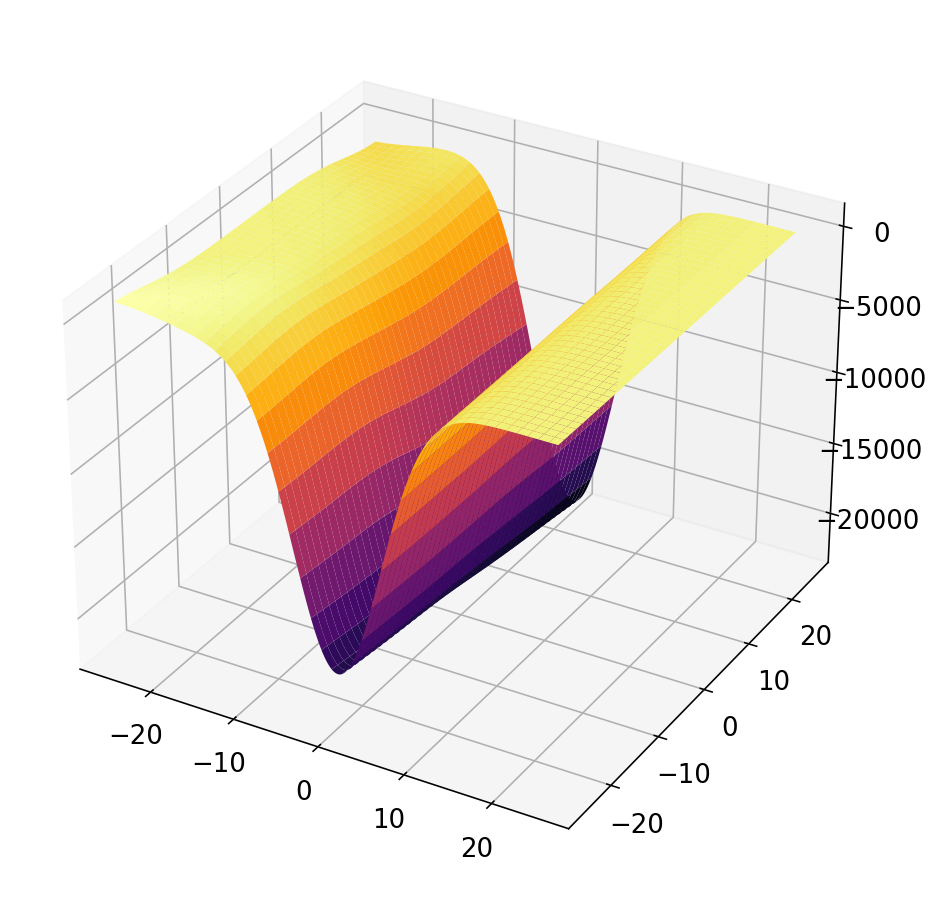

In [208]:
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(Z*1e5, X*1e5, gaga3+gaga2+gaga1 , cmap='inferno', zorder=1)

In [236]:
gaga_all = gaga1+gaga2+gaga3

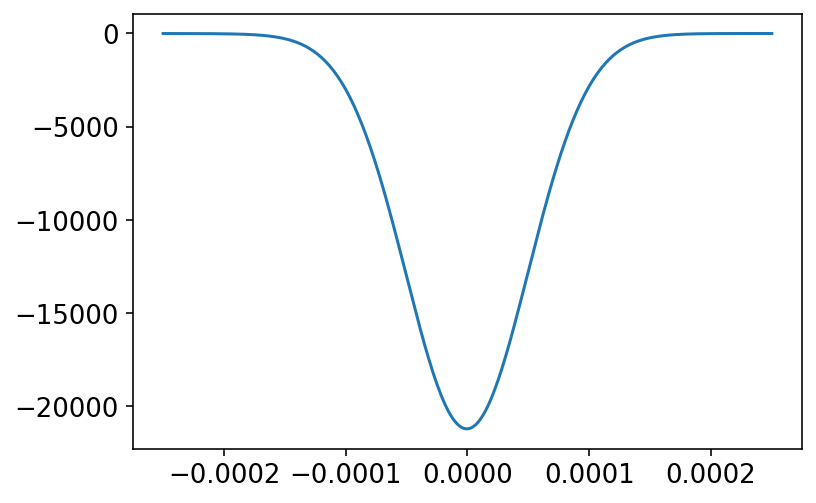

In [242]:
x_observe = 0
x_observe_index = np.argmin(np.abs(xvec - x_observe))

plt.plot(zvec,gaga_all[:,x_observe_index])

#x_observe = 2.5*sigma_x
#x_observe_index = np.argmin(np.abs(xvec - x_observe))

#plt.plot(zvec,gaga_all[:,x_observe_index])

#x_observe = -2.5*sigma_x
#x_observe_index = np.argmin(np.abs(xvec - x_observe))

#plt.plot(zvec,gaga_all[:,x_observe_index])

In [243]:
haha = np.array(list(zip(zvec,gaga_all[:,x_observe_index])))
np.savetxt('Wx_total_x_0.dat',haha)

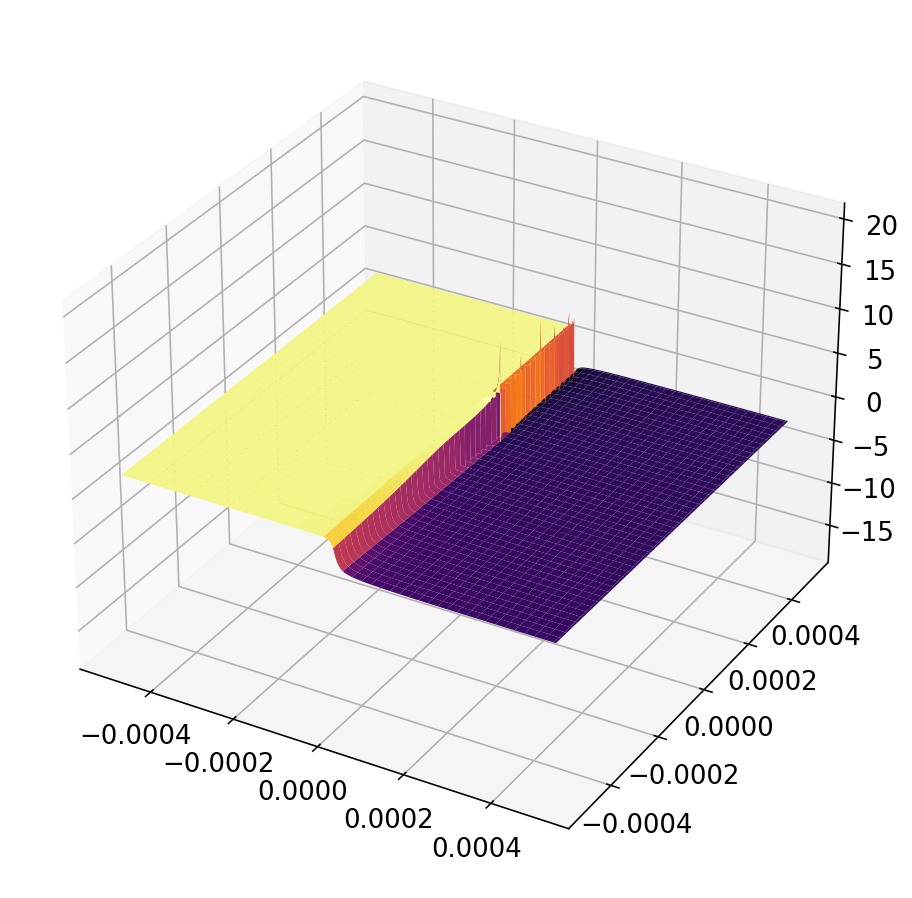

In [84]:
Z2, X2 = np.meshgrid(zvec2, xvec2, indexing='ij')
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(Z2, X2, psi_x_grid , cmap='inferno', zorder=1)

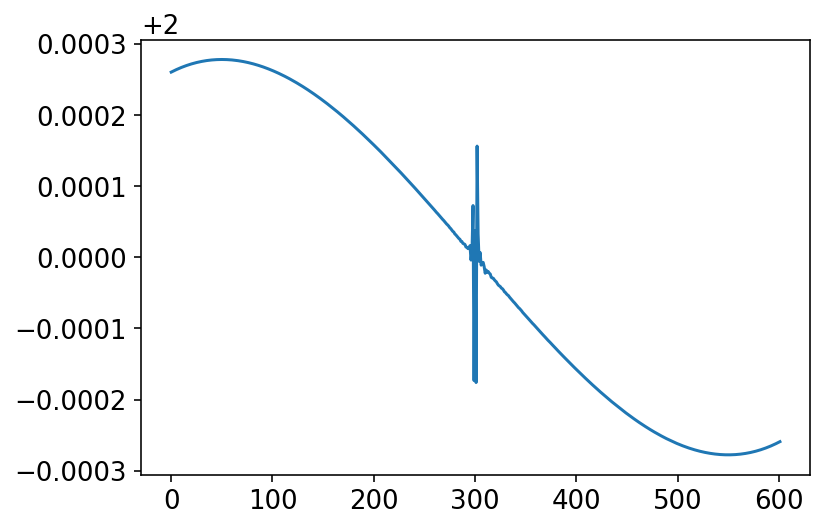

In [86]:
plt.plot(psi_x_grid[50,:])

In [87]:
rho

1.5

In [141]:
my_2d_convolve2(lambda_grid_filtered_prime_bounded, psi_x_grid, 150, 150)

-5103412562838186.0

In [31]:
from numba import njit
@njit
def my_2d_convolve2(g1, g2, ix1, ix2):
    d1, d2 = g1.shape
    g2_flip = np.flip(g2)
    g2_cut = g2_flip[d1-ix1:2*d1-ix1, d2-ix2:2*d2-ix2]
    
    sums = 0
    for i in range(d1):
        for j in range(d2):
            sums+= g1[i,j]*g2_cut[i,j]
    return sums

x_observe_index : 154


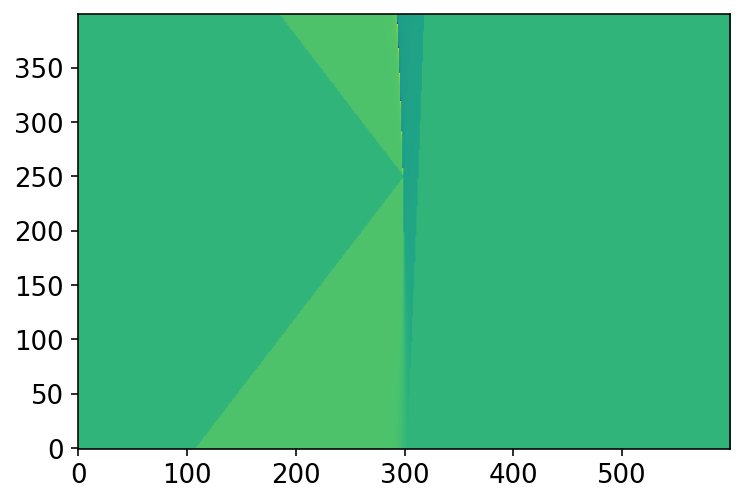

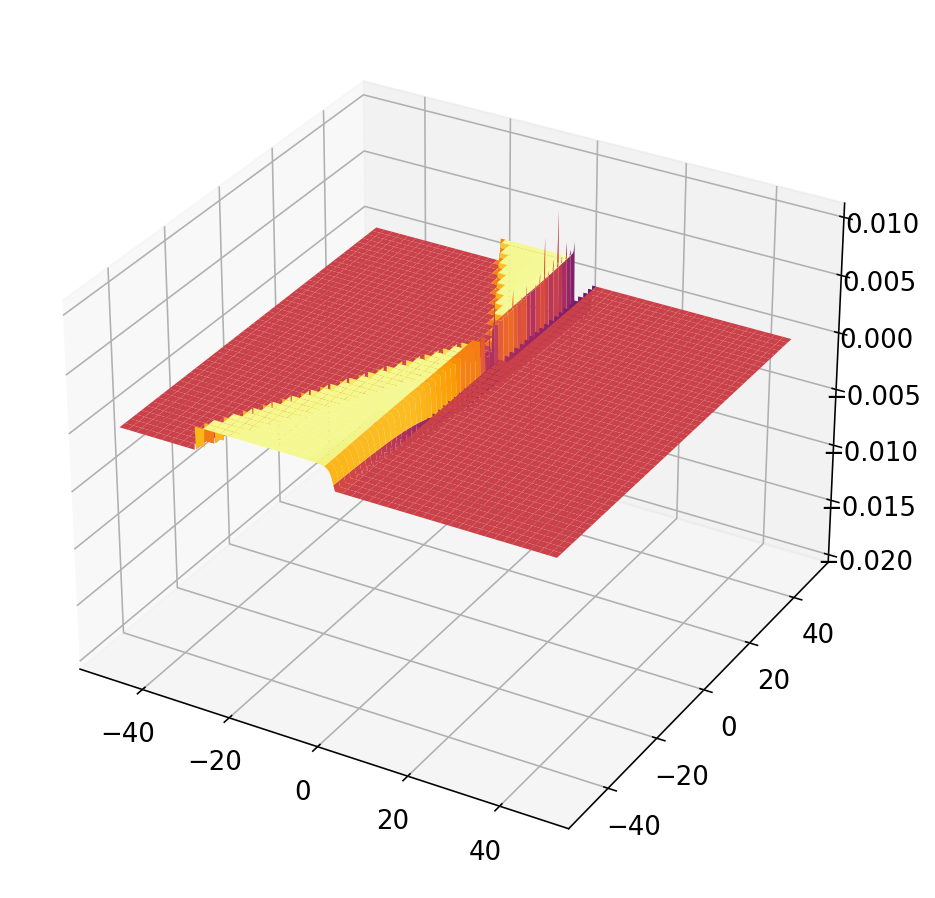

In [108]:
lz = compute_transient_wake_case_B(0.1/rho, 2.5*sigma_x, zvec2, xvec2, dz, dx, lambda_grid_filtered_prime, psi_s_grid, psi_x_grid);

# Results

x_observe_index : 51
x_observe_index : 102
x_observe_index : 154


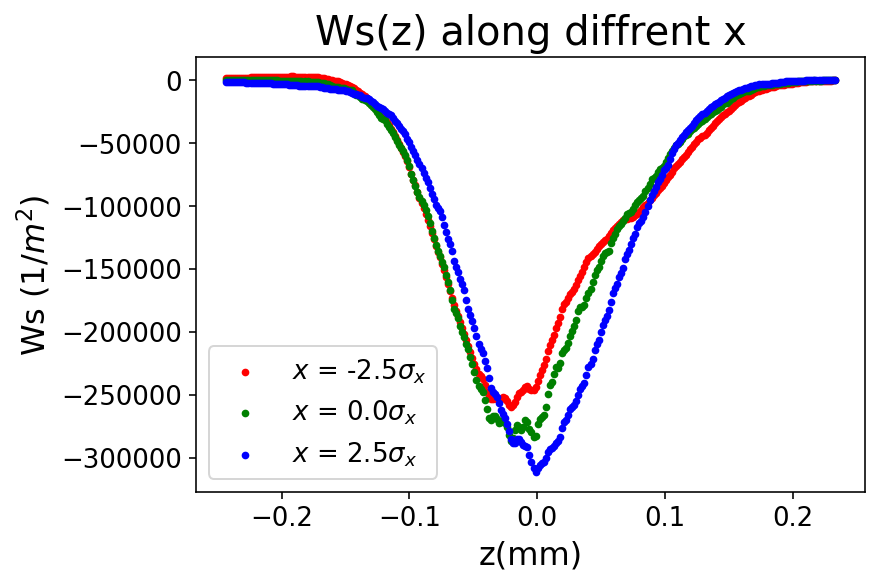

In [122]:
# Check with Yunhai's example

xo_vec = [-2.5*sigma_x, 0.0, 2.5*sigma_x]

ffB = lambda xo : compute_transient_wake_case_B(0.1/rho, xo, zvec2, xvec2, dz, dx, lambda_grid_filtered_prime, psi_s_grid, psi_x_grid)
wake_listB = np.array(list(map(ffB, xo_vec)))

ws1 = wake_listB[0][0] + wake_listB[0][1] + wake_listB[0][2]
ws2 = wake_listB[1][0] + wake_listB[1][1] + wake_listB[1][2]
ws3 = wake_listB[2][0] + wake_listB[2][1] + wake_listB[2][2]

plt.scatter(zvec*10**3, ws1, color='red', label='$x$ = '+str(xo_vec[0]/sigma_x) + '$\sigma_x$', s=8 )
plt.scatter(zvec*10**3, ws2, color='green', label='$x$ = '+str(xo_vec[1]/sigma_x) + '$\sigma_x$', s=8 )
plt.scatter(zvec*10**3, ws3, color='blue', label='$x$ = '+str(xo_vec[2]/sigma_x) + '$\sigma_x$', s=8 )

plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('Ws $(1/m^2)$', fontsize=16)
#plt.title('Ws(z) along x='+str(x_observe*1000)+' mm \n Case B, zi-boundary term',  fontsize=20)
#plt.title('Ws(z) along x=' + str(x_observe*1000) +'mm',  fontsize=20)

plt.title('Ws(z) along diffrent x',  fontsize=20)
plt.legend()

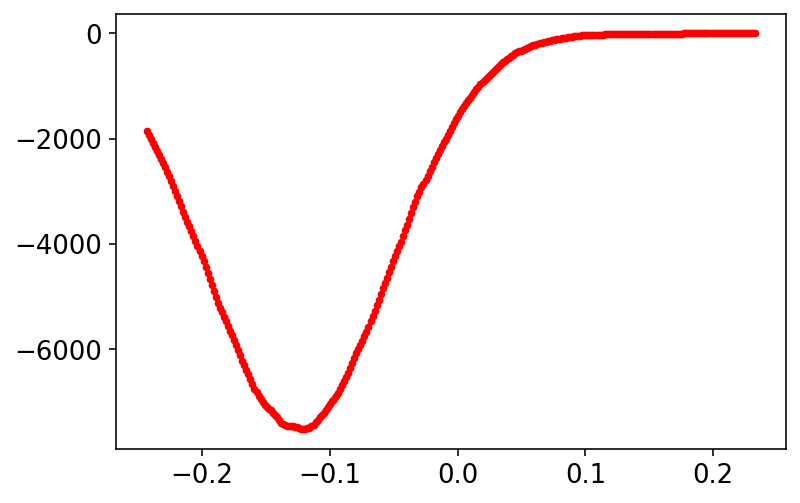

In [64]:
#ws1 = wake_listB[0][3] + wake_listB[0][4] + wake_listB[0][5]
ws1 = wake_listB[0][5] 

plt.scatter(zvec*10**3, ws1, color='red', label='$x$ = '+str(xo_vec[0]/sigma_x) + '$\sigma_x$', s=8 )


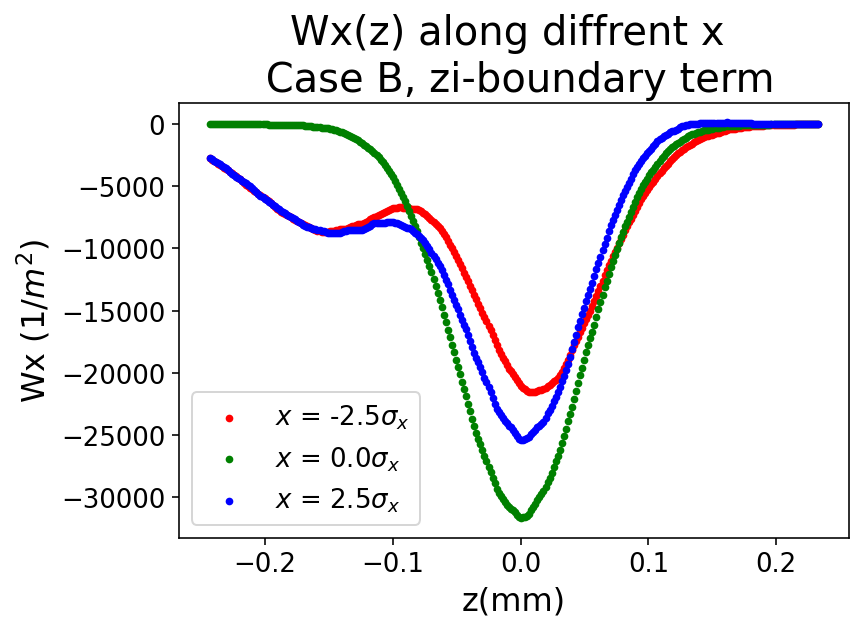

In [95]:
wx1 = wake_listB[0][3] + wake_listB[0][4] + wake_listB[0][5]
wx2 = wake_listB[1][3] + wake_listB[1][4] + wake_listB[1][5]
wx3 = wake_listB[2][3] + wake_listB[2][4] + wake_listB[2][5]

plt.scatter(zvec*10**3, wx1, color='red', label='$x$ = '+str(xo_vec[0]/sigma_x) + '$\sigma_x$', s=8 )
plt.scatter(zvec*10**3, wx2, color='green', label='$x$ = '+str(xo_vec[1]/sigma_x) + '$\sigma_x$', s=8 )
plt.scatter(zvec*10**3, wx3, color='blue', label='$x$ = '+str(xo_vec[2]/sigma_x) + '$\sigma_x$', s=8 )

plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('Wx $(1/m^2)$', fontsize=16)
plt.title('Wx(z) along diffrent x \n Case B, zi-boundary term',  fontsize=20)
plt.legend()

In [45]:
0.1/rho

0.06666666666666667

In [77]:
# Check at many phi locations

#x_observe = 0.0

x_observe = 2.5*sigma_x

#ffA = lambda a : csr2d_kick_calc_case_A(beam[4], beam[0], charges,
#    gamma=gamma, rho=rho, phi = a, x_observe = 0,
#    nz=200, nx=150, debug=True)

ffB = lambda a : compute_transient_wake_case_B(a, x_observe, zvec2, xvec2, dz, dx, lambda_grid_filtered_prime, psi_s_grid, psi_x_grid)
phi_vec = [0.1/rho, 0.06, 0.08, 0.1, 0.12, 0.14]
#phi_vec = [0.04, 0.06, 0.08, 0.12, 0.16, 0.2, 0.24]
#phi_vec = [0.04]
wake_list = list(map(ffB, phi_vec))

x_observe_index : 154
x_observe_index : 154
x_observe_index : 154
x_observe_index : 154
x_observe_index : 154
x_observe_index : 154


In [10]:
def lamb_1d(z):
    return 1/(sigma_z*np.sqrt(2*np.pi))* np.exp(-z**2 / 2 / sigma_z**2)
def lamb_1d_prime(z):
    return 1/(sigma_z*np.sqrt(2*np.pi))* np.exp(-z**2 / 2 / sigma_z**2) * (-z / sigma_z**2)
def plot_Ws_caseB_zi_term_theory(phi, color, label=None):
    plt.plot(zvec*1e3, -4/phi/rho * lamb_1d( zvec - rho*phi**3/24), color = color, linewidth=4, label = label)
    
def plot_Wx_caseB_theory(phi, color, label=None):
    plt.plot(zvec*1e3, -4/rho * lamb_1d( zvec ), color = color, linewidth=4, label = label)

In [76]:
from scipy import integrate

# Case B integral term ( for large phi this goes to the s-s wake )
def get_Wss(zo):
    w_ss = lambda z: -2/(3*rho**2)**(1/3)*lamb_1d_prime(z)/(zo - z)**(1/3)
    return integrate.quad(w_ss, zo - rho*phi**3/24, zo)[0]

phi = phi_vec[0]
Wss_list1 = np.array(list(map(get_Wss, zvec)))
phi = phi_vec[1]
Wss_list2 = np.array(list(map(get_Wss, zvec)))
phi = phi_vec[2]
Wss_list3 = np.array(list(map(get_Wss, zvec)))
phi = phi_vec[3]
Wss_list4 = np.array(list(map(get_Wss, zvec)))
phi = phi_vec[4]
Wss_list5 = np.array(list(map(get_Wss, zvec)))
phi = phi_vec[5]
Wss_list6 = np.array(list(map(get_Wss, zvec)))

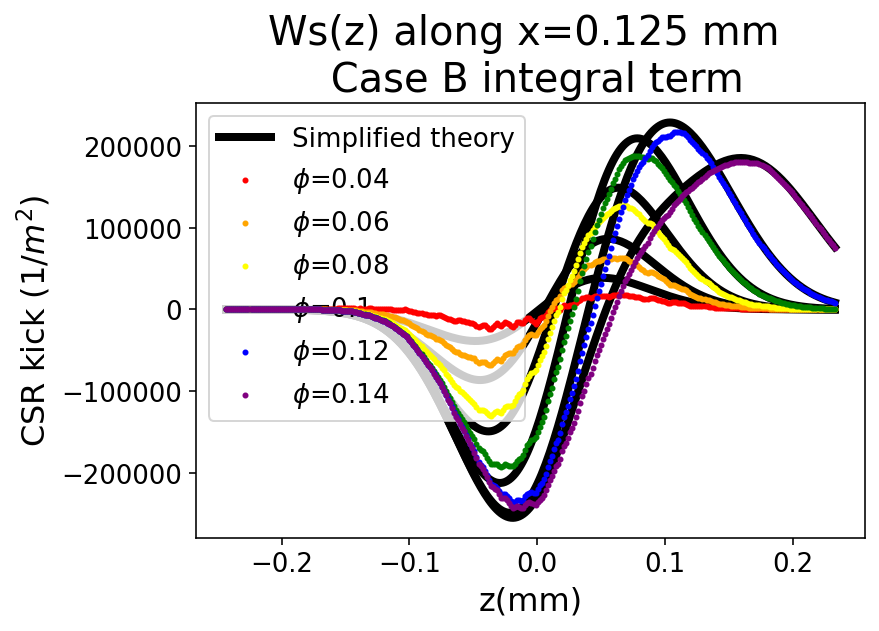

In [77]:
plt.scatter(zvec*10**3,wake_list[0][0], color='red', label='$\phi$='+str(phi_vec[0]), zorder=10, s=4 )
plt.scatter(zvec*10**3,wake_list[1][0], color='orange', label='$\phi$='+str(phi_vec[1]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list[2][0], color='yellow', label='$\phi$='+str(phi_vec[2]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list[3][0], color='green', label='$\phi$='+str(phi_vec[3]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list[4][0], color='blue', label='$\phi$='+str(phi_vec[4]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list[5][0], color='purple', label='$\phi$='+str(phi_vec[5]), zorder=10, s=4  )

plt.plot(zvec*1e3, Wss_list1, color = 'black', linewidth=4, label = 'Simplified theory')
plt.plot(zvec*1e3, Wss_list2, color = 'black', linewidth=4)
plt.plot(zvec*1e3, Wss_list3, color = 'black', linewidth=4)
plt.plot(zvec*1e3, Wss_list4, color = 'black', linewidth=4)
plt.plot(zvec*1e3, Wss_list5, color = 'black', linewidth=4)
plt.plot(zvec*1e3, Wss_list6, color = 'black', linewidth=4)

plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
plt.title('Ws(z) along x='+str(x_observe*1000)+' mm \n Case B integral term',  fontsize=20)
plt.legend(loc='upper left')

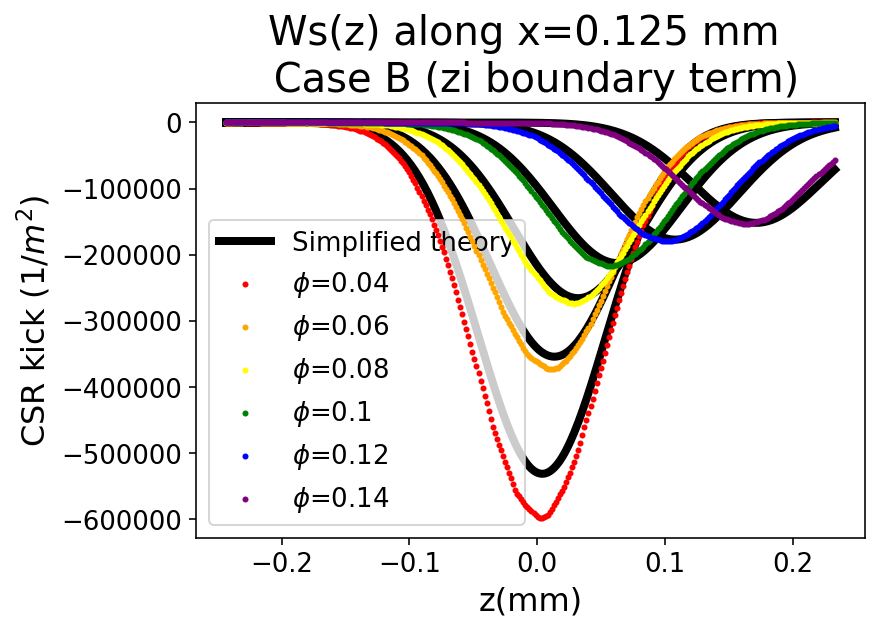

In [79]:
plt.scatter(zvec*10**3,wake_list[0][1], color='red', label='$\phi$='+str(phi_vec[0]), zorder=10, s=4)
plt.scatter(zvec*10**3,wake_list[1][1], color='orange', label='$\phi$='+str(phi_vec[1]),zorder=10, s=4  )
plt.scatter(zvec*10**3,wake_list[2][1], color='yellow', label='$\phi$='+str(phi_vec[2]),zorder=10, s=4  )
plt.scatter(zvec*10**3,wake_list[3][1], color='green', label='$\phi$='+str(phi_vec[3]),zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list[4][1], color='blue', label='$\phi$='+str(phi_vec[4]), zorder=10, s=4  )
plt.scatter(zvec*10**3,wake_list[5][1], color='purple', label='$\phi$='+str(phi_vec[5]),zorder=10, s=4  )


plot_Ws_caseB_zi_term_theory(phi_vec[0], 'black', 'Simplified theory')
plot_Ws_caseB_zi_term_theory(phi_vec[1], 'black')
plot_Ws_caseB_zi_term_theory(phi_vec[2], 'black')
plot_Ws_caseB_zi_term_theory(phi_vec[3], 'black')
plot_Ws_caseB_zi_term_theory(phi_vec[4], 'black')
plot_Ws_caseB_zi_term_theory(phi_vec[5], 'black')

plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
plt.title('Ws(z) along x='+str(x_observe*1000)+' mm \n Case B (zi boundary term)',  fontsize=20)
plt.legend()

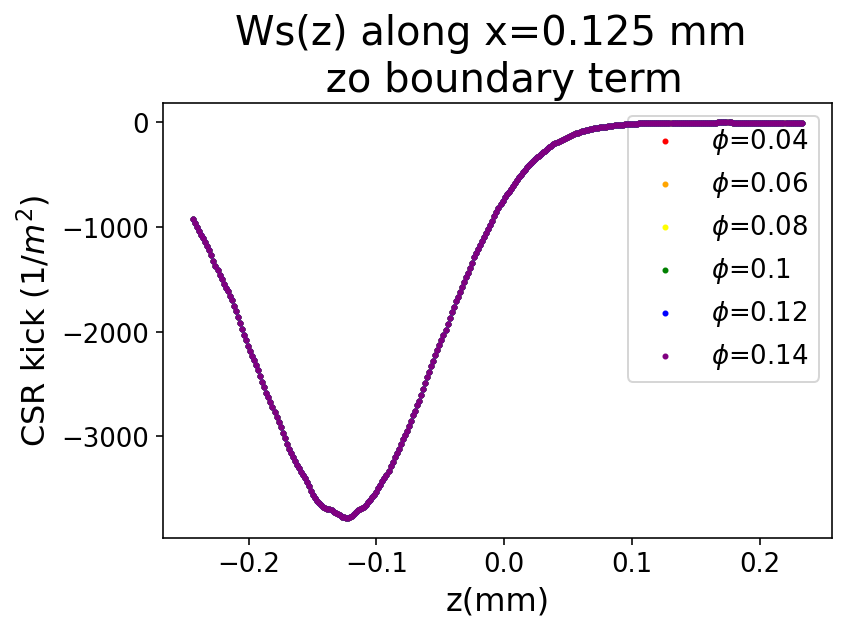

In [80]:
# The zo boundary term should be small comparing to the other 2 terms

plt.scatter(zvec*10**3,wake_list[0][2], color='red', label='$\phi$='+str(phi_vec[0]), zorder=10, s=4)
plt.scatter(zvec*10**3,wake_list[1][2], color='orange', label='$\phi$='+str(phi_vec[1]),zorder=10, s=4  )
plt.scatter(zvec*10**3,wake_list[2][2], color='yellow', label='$\phi$='+str(phi_vec[2]),zorder=10, s=4  )
plt.scatter(zvec*10**3,wake_list[3][2], color='green', label='$\phi$='+str(phi_vec[3]),zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list[4][2], color='blue', label='$\phi$='+str(phi_vec[4]), zorder=10, s=4  )
plt.scatter(zvec*10**3,wake_list[5][2], color='purple', label='$\phi$='+str(phi_vec[5]),zorder=10, s=4  )

plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
plt.title('Ws(z) along x='+str(x_observe*1000)+' mm \n zo boundary term',  fontsize=20)
plt.legend(loc='upper right')

In [49]:
# Check at many phi locations

#x_observe = 0.0

x_observe = 2.5*sigma_x

#ffA = lambda a : csr2d_kick_calc_case_A(beam[4], beam[0], charges,
#    gamma=gamma, rho=rho, phi = a, x_observe = 0,
#    nz=200, nx=150, debug=True)

ffB = lambda a : compute_transient_wake_case_B(a, x_observe, zvec2, xvec2, dz, dx, lambda_grid_filtered_prime, psi_s_grid, psi_x_grid)
phi_vec = [0.1/rho, 0.06, 0.08, 0.1, 0.12, 0.14]
#phi_vec = [0.04, 0.06, 0.08, 0.12, 0.16, 0.2, 0.24]
#phi_vec = [0.04]
wake_list = list(map(ffB, phi_vec))

x_observe_index : 224
x_observe_index : 224
x_observe_index : 224
x_observe_index : 224
x_observe_index : 224
x_observe_index : 224


Text(0.5, 1.0, 'Wx(z) along x=0.125 mm \n Case B (integral term)')

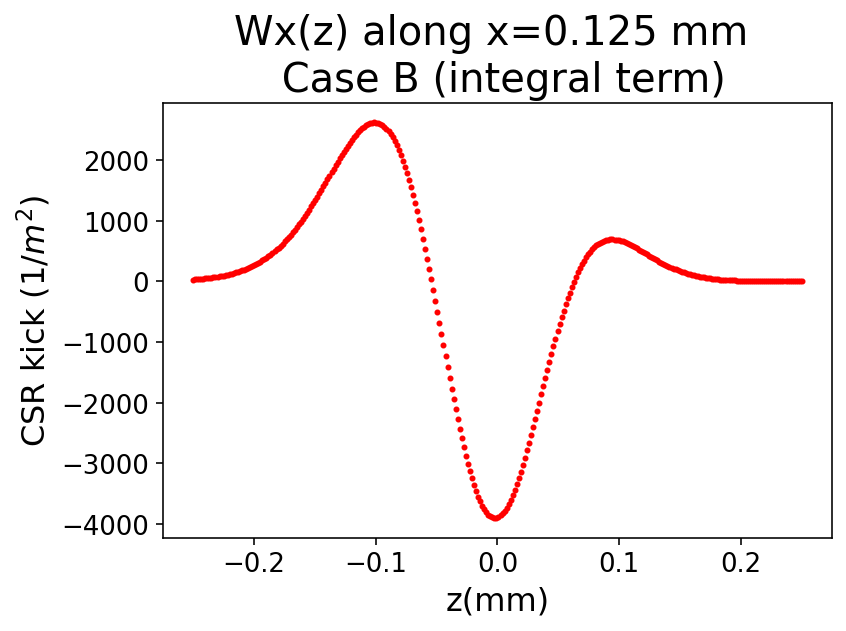

In [50]:
# Wx(z) on axis

wx1 = wake_list[0][3] + wake_list[0][4] + wake_list[0][5] 
wx2 = wake_list[1][3] + wake_list[1][4] + wake_list[1][5]
wx3 = wake_list[2][3] + wake_list[2][4] + wake_list[2][5]
wx4 = wake_list[3][3] + wake_list[3][4] + wake_list[3][5]
wx5 = wake_list[4][3] + wake_list[4][4] + wake_list[4][5]
wx6 = wake_list[5][3] + wake_list[5][4] + wake_list[5][5]


wx1 = wake_list[0][3] 
#wx2 = wake_list[1][3] + wake_list[1][4] 
#wx3 = wake_list[2][3] + wake_list[2][4] 
#wx4 = wake_list[3][3] + wake_list[3][4]
#wx5 = wake_list[4][3] + wake_list[4][4]
#wx6 = wake_list[5][3] + wake_list[5][4]

plt.scatter(zvec*10**3, wx1, color='red', label='$\phi$='+str(phi_vec[0]), zorder=10, s=4)
#plt.scatter(zvec*10**3, wx2, color='orange', label='$\phi$='+str(phi_vec[1]),zorder=10, s=4  )
#plt.scatter(zvec*10**3, wx3, color='yellow', label='$\phi$='+str(phi_vec[2]),zorder=10, s=4  )
#plt.scatter(zvec*10**3, wx4, color='green', label='$\phi$='+str(phi_vec[3]),zorder=10, s=4   )
#plt.scatter(zvec*10**3, wx5, color='blue', label='$\phi$='+str(phi_vec[4]), zorder=10, s=4  )
#plt.scatter(zvec*10**3, wx6, color='purple', label='$\phi$='+str(phi_vec[5]),zorder=10, s=4  )


#plot_Wx_caseB_theory(phi_vec[0], 'black', 'Simplified theory')
#plot_Wx_caseB_theory(phi_vec[1], 'black')
#plot_Wx_caseB_theory(phi_vec[2], 'black')
#plot_Wx_caseB_theory(phi_vec[3], 'black')
#plot_Wx_caseB_theory(phi_vec[4], 'black')
#plot_Wx_caseB_theory(phi_vec[5], 'black')

plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
plt.title('Wx(z) along x='+str(x_observe*1000)+' mm \n Case B (integral term)',  fontsize=20)
#plt.legend()

In [30]:
z_observe = 0
z_observe_index = np.argmin(np.abs(zvec - z_observe))
print('z_observe_index :', z_observe_index )
wx1[z_observe_index]

z_observe_index : 153


-4077.7233309063017

Text(0.5, 1.0, 'Wx(z) along x=0.125 mm \n Case B (zo boundary term)')

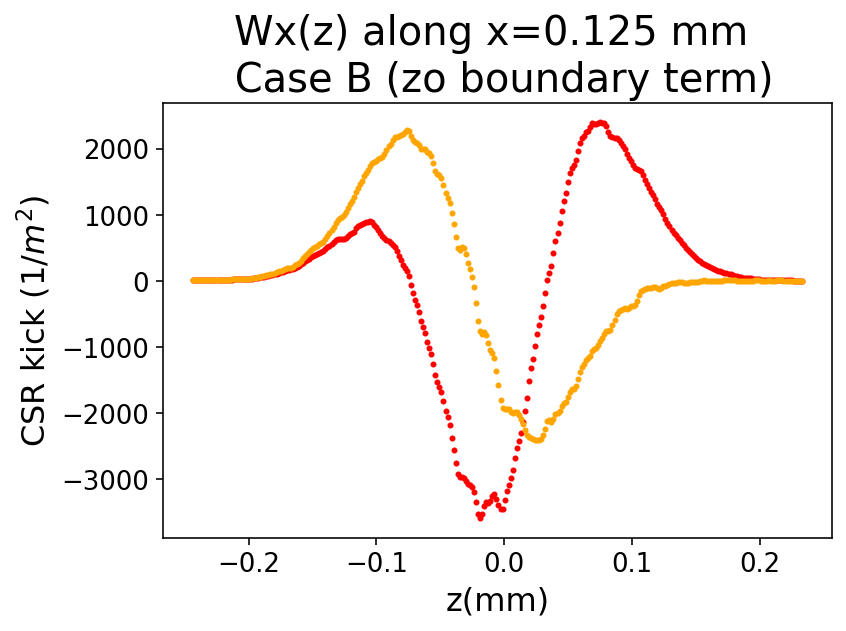

In [126]:
# Check the three contribution terms of Wx(z)
# ix_term is...
#    3 : Wx integral term
#    4 : Wx zi term
#    5 : Wx zo term

ix_term = 3
wx1 = wake_list[0][ix_term] 
wx2 = wake_list[1][ix_term] 
wx3 = wake_list[2][ix_term] 
wx4 = wake_list[3][ix_term] 
wx5 = wake_list[4][ix_term] 
wx6 = wake_list[5][ix_term] 

plt.scatter(zvec*10**3, wx1, color='red', label='$\phi$='+str(phi_vec[0]), zorder=10, s=4)
plt.scatter(zvec*10**3, wx2, color='orange', label='$\phi$='+str(phi_vec[1]),zorder=10, s=4  )
#plt.scatter(zvec*10**3, wx3, color='yellow', label='$\phi$='+str(phi_vec[2]),zorder=10, s=4  )
#plt.scatter(zvec*10**3, wx4, color='green', label='$\phi$='+str(phi_vec[3]),zorder=10, s=4   )
#plt.scatter(zvec*10**3, wx5, color='blue', label='$\phi$='+str(phi_vec[4]), zorder=10, s=4  )
#plt.scatter(zvec*10**3, wx6, color='purple', label='$\phi$='+str(phi_vec[5]),zorder=10, s=4  )

#plot_Wx_caseB_theory(phi_vec[0], 'black', 'Simplified theory')


plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
#plt.title('Wx(z) along x='+str(x_observe*1000)+' mm \n Case B (zi boundary term)',  fontsize=20)
plt.title('Wx(z) along x='+str(x_observe*1000)+' mm \n Case B (zo boundary term)',  fontsize=20)
#plt.legend()

In [68]:
haha = np.array(list(zip(zvec,wx1)))

In [69]:
haha = np.array(list(zip(zvec,wx1)))
np.savetxt('Wx_int_x_2.5sig_CSR2D.dat',haha)